In [ ]:
'''
From Xinlian:
From the science perspective, it is maybe worth quickly run the mediation analysis, as simple as the step 1,2,3 
 on the wiki page. Given that the ecDNA is still significant after adjusting for the p53 mutation but with a decreased 
 coefficient, I think these are reasonable suggestive evidence for a little bit of both direct and indirect effects of ecDNA.

	Baron & Kenny:
	1. Regress the dependent variable on the independent variable to confirm that the independent variable is a significant 
	 predictor of the dependent variable.
	2. Regress the mediator on the independent variable to confirm that the independent variable is a significant predictor 
	 of the mediator. If the mediator is not associated with the independent variable, then it couldn’t possibly mediate anything.
	3. Regress the dependent variable on both the mediator and independent variable to confirm that a) the mediator is a significant 
	 predictor of the dependent variable, and b) the strength of the coefficient of the previously significant independent variable 
	 in Step #1 is now greatly reduced, if not rendered nonsignificant.
     
Addenda (OSC)
- Cox model not valid in Baron-Kenny mediation analysis according to [1,2]. We use Weibull Accelerated Failure Time (WAFT) instead.


1. Mediation analysis with a time-to-event outcome: a review of use and reporting in healthcare research
	(2018) BMC Medical Research Methodology https://doi.org/10.1186/s12874-018-0578-7
2. Causal Mediation Analysis for the Cox Proportional Hazards Model with a Smooth Baseline Hazard Estimator
	(2016) J R Stat Soc Ser C Appl Stat.
'''

In [1]:
# 0. Get data

import pandas as pd
import numpy as np

from lifelines.statistics import logrank_test
from lifelines import LogNormalAFTFitter, LogLogisticAFTFitter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#plt.rcParams['svg.fonttype'] = 'Arial'
import os
import sys
sys.path.append(os.path.abspath( '/mnt/c/Users/ochapman/Documents/Mesirov/Software/oscutils'))
import get
pd.set_option('display.max_columns', None)
#os.chdir('/home/ochapman/Documents/Mesirov/medullo_ecDNA/TCGA-lifelines-survival')
print(os.getcwd())

try:
    os.mkdir('out')
except OSError as error:
    print(error)

/mnt/c/Users/ochapman/Documents/Mesirov/medullo_ecDNA/src/survival
[Errno 17] File exists: 'out'


In [18]:
def get_pfs(censor_years=None):
    pfs = get.medullo_patients()
    pfs.ecDNA = pfs.ecDNA.map({
        'yes':True,
    }).fillna(False).astype(bool)
    pfs = pfs.dropna(subset=['Survival_time_years','ecDNA','Vital_status'])
    pfs.Vital_status = pfs.Vital_status.map({
        'alive':False,
        'deceased':True
    })
    # event observed if patient has documented relapse or dies.
    pfs.Relapse_status = pfs.apply(axis=1,
                                   func=lambda x:  (not (np.isnan(x["Relapse_interval_years"]))) or x['Vital_status'])
    pfs['Relapse_interval_years'] = pfs.apply(axis=1,
                                              func=lambda x: x['Survival_time_years'] if np.isnan(x['Relapse_interval_years']) else x['Relapse_interval_years'])
    if type(censor_years) == int:
        rows = (pfs['Relapse_interval_years'] > censor_years)
        print("Right-censoring {} intervals to {} years...".format(rows.sum(),censor_years))
        pfs.loc[rows,'Relapse_status'] = False
        pfs.loc[rows,'Relapse_interval_years'] = censor_years
    return pfs

def get_p53_mut(samples):
    '''
    Return series of samples annotated with p53 status (p53-wt, p53-mut)
    '''
    df = get.medullo_p53()
    # Include only samples for which germline and somatic mutations are available
    df = df[(df.somatic_mut_available) & (df.germline_mut_available)]
    # compute p53 status
    df['somatic_tp53_mut'] = df['somatic_tp53_mut'].fillna(False)
    df['p53_mut'] = df.somatic_tp53_mut.astype(bool) | df['ClinVAR/VEP'].astype(bool)
    # subset
    df = df[df.index.isin(samples)]
    return df.p53_mut
def annotate_p53_mut(df):
    p53_status = get_p53_mut(df.index)
    df = df.join(p53_status,how='inner')
    return df

def map_cbtn(key=None,value=None):
    df = get.medullo_samples()
    df=df[df.index.map(lambda x: str(x).startswith('BS'))]
    if key == None or value == None:
        return df
    else:
        df["Sample_ID"] = df.index
        return df.set_index(key)[value].to_dict()
def preprocess_ac(df):
    # drop ampliconx suffix
    df['sample_name']=df['sample_name'].map(lambda x: '_'.join(x.split('_')[:-1]))
    # drop feature suffix
    df['feature']=df['feature'].map(lambda x: x.split('_')[0])
    # map cbtn sample names
    d=map_cbtn('Aliases','Sample_ID')
    df['sample_name']=df['sample_name'].map(lambda x: d[x] if x in d.keys() else x)
    df['sample_name']=df['sample_name'].map(lambda x: x.split('.')[0])
    # map grch37 ids
    df['sample_name']=df['sample_name'].map(lambda x: x[:-3] if x.endswith('_AA') else x)
    # map patient ids
    d=get.medullo_samples()['Patient_ID'].to_dict()
    df['Patient_ID']=df['sample_name'].map(lambda x: d[x] if x in d.keys() else x)
    return df
def get_MYC_amp_patients():
    DIR="/home/ochapman/Documents/Mesirov/medullo_ecDNA/data/AmpliconClassifier/latest"
    hg38_set=pd.read_csv(DIR+"/hg38_gene_list.tsv",sep='\t')
    hg38_set=preprocess_ac(hg38_set)
    hg38_set=hg38_set[hg38_set.gene=='MYC']
    pts = set(hg38_set['Patient_ID'])
    hg19_set=pd.read_csv(DIR+'/grch37_gene_list.tsv',sep='\t')
    hg19_set=preprocess_ac(hg19_set)
    hg19_set=hg19_set[hg19_set.gene=='MYC']
    pts = pts | set(hg19_set['Patient_ID']) | set(['MB106','MB260'])
    return pts
def get_MYCN_amp_patients():
    DIR="/home/ochapman/Documents/Mesirov/medullo_ecDNA/data/AmpliconClassifier/latest"
    hg38_set=pd.read_csv(DIR+"/hg38_gene_list.tsv",sep='\t')
    hg38_set=preprocess_ac(hg38_set)
    hg38_set=hg38_set[hg38_set.gene=='MYCN']
    pts = set(hg38_set['Patient_ID'])
    hg19_set=pd.read_csv(DIR+'/grch37_gene_list.tsv',sep='\t')
    hg19_set=preprocess_ac(hg19_set)
    hg19_set=hg19_set[hg19_set.gene=='MYCN']
    pts=pts | set(hg19_set['Patient_ID'])
    return pts
def annotate_myc_amp(df):
    myc_amp = get_MYC_amp_patients()
    df['myc_amp'] = df.index.isin(myc_amp)
    return df
def annotate_mycn_amp(df):
    mycn_amp = get_MYCN_amp_patients()
    df['mycn_amp'] = df.index.isin(mycn_amp)
    return df

# Cox regression: need to one-hot encode categorical (Subgroup) and Sex. Age as integer.
def pfs_cox_transform_p53(pfs):
    pfs=pfs.copy()
    pfs = pfs.dropna(subset=['Survival_time_years','ecDNA','Subgroup','Sex','Age_at_diagnosis'])
    pfs["Sex"] = pfs["Sex"].map({
        "f":0,
        "m":1,
    }).astype(int)
    pfs["WNT"] = pfs["Subgroup"] == 'WNT'
    pfs["SHH"] = pfs["Subgroup"] == 'SHH'
    pfs["G3"] = pfs["Subgroup"] == "G3"
    pfs["G4"] = pfs["Subgroup"] == 'G4'

    # drop WNT and unknown subgroup
    pfs=pfs[pfs.SHH | pfs.G3 | pfs.G4 | pfs.WNT]
    
    # hack hack
    pfs["Relapse_interval_years"] = pfs["Relapse_interval_years"]+.01
    
    pfs = pfs[["ecDNA","Relapse_interval_years","Relapse_status","Age_at_diagnosis","Sex","WNT","SHH","G3","p53_mut","myc_amp","mycn_amp"]]
    return pfs

def median_time_to_event(T,E):
    medIx = np.argsort(T)[len(T)//2]
    med=T[medIx]
    obs=E[medIx]
    if obs:
        print("Median time to event:",med)
    else:
        print("Median time to event is at least:",med,"(event not observed at median)")
    return(med,obs)

def plot_aft(aft):
    ax = aft.plot()
    sns.despine()
    for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    ax.set_xlabel("log time ratio (95% CI)")
    ax.set_xlim((-5,5.5))
    return ax

def lnaft_pfs(pfs,formula=None,outfile=None):
    lnaft = LogNormalAFTFitter()
    lnaft.fit(pfs, duration_col='Relapse_interval_years', event_col='Relapse_status',
            formula=formula)
    lnaft.print_summary()
    
    median_time_to_event(pfs['Relapse_interval_years'],pfs['Relapse_status'])
    ax = plot_aft(lnaft)

    if outfile != None:
        lnaft.summary.to_csv(outfile+'.tsv',sep='\t')
        plt.savefig(outfile+'.svg')
    
    return lnaft

Right-censoring 74 intervals to 5 years...


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.LogNormalAFTFitter: fitted with 322 total observations, 242 right-censored observations>
             duration col = 'Relapse_interval_years'
                event col = 'Relapse_status'
   number of observations = 322
number of events observed = 80
           log-likelihood = -248.15
         time fit was run = 2022-10-06 19:53:15 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                
mu_    Intercept          2.56      12.94       0.30             1.97             3.15                 7.19                23.29
       Age_at_diagnosis   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       G3                -1.43       0.24       0.29            -1.99            -0.87                 0.14                 0.42
       SHH               -0.65       0.52       0.32            -1.27            -0.02                 0.28                 0.98
       Sex                0.30       1.34       0.24            -0.18             0.77                 0.84                 2.16
       WNT                1.25       3.51       0.78            -0.28             2.79                 0.75                16.29
       p53_mut           -1.46       0.23       0.48            -2.40            -0.52                 0.09                 0.59
sigma_ Intercept          0.40       1.49       0.09             0.23             0.57                 1.26                 1.77

                            z      p   -log2(p)
param  covariate                               
mu_    Intercept         8.55 <0.005      56.11
       Age_at_diagnosis  0.53   0.60       0.74
       G3               -4.99 <0.005      20.69
       SHH              -2.03   0.04       4.57
       Sex               1.22   0.22       2.17
       WNT               1.60   0.11       3.19
       p53_mut          -3.05 <0.005       8.79
sigma_ Intercept         4.57 <0.005      17.65
---
Concordance = 0.71
AIC = 512.30
log-likelihood ratio test = 44.12 on 6 df
-log2(p) of ll-ratio test = 23.77

Median time to event is at least: 2.6766666666666596 (event not observed at median)


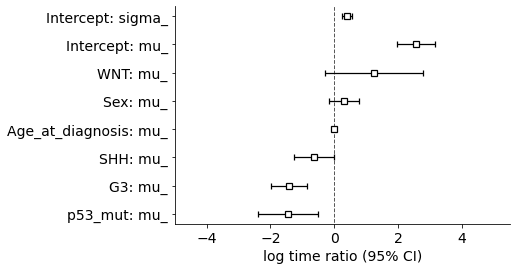

In [19]:
# 1. Regress the dependent variable on the independent variable to confirm that the independent variable is a significant 
#    predictor of the dependent variable.

pfs = get_pfs(censor_years=5)
pfs = annotate_p53_mut(pfs)
pfs = annotate_myc_amp(pfs)
pfs = annotate_mycn_amp(pfs)
#pfs
pfs = pfs_cox_transform_p53(pfs)
formula="WNT + SHH + G3 + Sex + Age_at_diagnosis + p53_mut"
lnaft_p53 = lnaft_pfs(pfs,formula,"out/lnaft_no_ecDNA")
# p53_coef = -1.46, p < 0.005

In [6]:
# 2. Regress the mediator on the independent variable to confirm that the independent variable is a significant predictor 
# 	 of the mediator. If the mediator is not associated with the independent variable, then it couldn’t possibly mediate 
#    anything.

# Done in p53 analysis

/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.LogNormalAFTFitter: fitted with 322 total observations, 242 right-censored observations>
             duration col = 'Relapse_interval_years'
                event col = 'Relapse_status'
   number of observations = 322
number of events observed = 80
           log-likelihood = -244.10
         time fit was run = 2022-10-06 19:54:01 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                
mu_    Intercept          2.66      14.36       0.30             2.08             3.25                 7.96                25.88
       Age_at_diagnosis   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       G3                -1.38       0.25       0.28            -1.93            -0.84                 0.15                 0.43
       SHH               -0.62       0.54       0.31            -1.23            -0.02                 0.29                 0.98
       Sex                0.28       1.32       0.24            -0.19             0.74                 0.83                 2.09
       WNT                0.91       2.49       0.76            -0.57             2.39                 0.57                10.96
       ecDNA             -0.81       0.44       0.28            -1.37            -0.26                 0.26                 0.77
       p53_mut           -0.94       0.39       0.49            -1.91             0.02                 0.15                 1.02
sigma_ Intercept          0.37       1.44       0.09             0.20             0.54                 1.22                 1.71

                            z      p   -log2(p)
param  covariate                               
mu_    Intercept         8.86 <0.005      60.15
       Age_at_diagnosis  0.65   0.51       0.96
       G3               -4.98 <0.005      20.59
       SHH              -2.02   0.04       4.52
       Sex               1.17   0.24       2.04
       WNT               1.21   0.23       2.13
       ecDNA            -2.88 <0.005       7.98
       p53_mut          -1.91   0.06       4.16
sigma_ Intercept         4.21 <0.005      15.26
---
Concordance = 0.73
AIC = 506.19
log-likelihood ratio test = 52.23 on 7 df
-log2(p) of ll-ratio test = 27.50

Median time to event is at least: 2.6766666666666596 (event not observed at median)


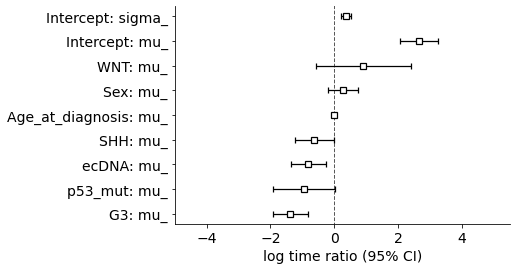

In [20]:
# 3. Regress the dependent variable on both the mediator and independent variable to confirm that a) the mediator is a 
# 	 significant predictor of the dependent variable, and b) the strength of the coefficient of the previously significant 
# 	 independent variable in Step #1 is now greatly reduced, if not rendered nonsignificant.

formula="ecDNA + WNT + SHH + G3 + Sex + Age_at_diagnosis + p53_mut"
lnaft_p53 = lnaft_pfs(pfs,formula,"out/lnaft_with_ecDNA")
# p53 coef = -0.94, p = 0.06

# Mediation 2

In [8]:
# 2 See association-tests/myc-family-associations

/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.LogNormalAFTFitter: fitted with 322 total observations, 242 right-censored observations>
             duration col = 'Relapse_interval_years'
                event col = 'Relapse_status'
   number of observations = 322
number of events observed = 80
           log-likelihood = -240.62
         time fit was run = 2022-10-06 19:55:50 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                
mu_    Intercept          2.53      12.60       0.29             1.96             3.11                 7.10                22.36
       Age_at_diagnosis   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       G3                -1.22       0.30       0.28            -1.77            -0.67                 0.17                 0.51
       SHH               -0.64       0.53       0.30            -1.24            -0.04                 0.29                 0.96
       Sex                0.36       1.43       0.23            -0.10             0.82                 0.91                 2.26
       WNT                0.97       2.65       0.74            -0.48             2.43                 0.62                11.38
       ecDNA             -0.33       0.72       0.35            -1.02             0.37                 0.36                 1.44
       myc_amp           -1.42       0.24       0.54            -2.48            -0.36                 0.08                 0.70
       mycn_amp          -0.55       0.58       0.51            -1.55             0.45                 0.21                 1.57
       p53_mut           -1.02       0.36       0.48            -1.97            -0.07                 0.14                 0.94
sigma_ Intercept          0.34       1.41       0.09             0.17             0.51                 1.19                 1.67

                            z      p   -log2(p)
param  covariate                               
mu_    Intercept         8.65 <0.005      57.46
       Age_at_diagnosis  0.86   0.39       1.36
       G3               -4.34 <0.005      16.12
       SHH              -2.10   0.04       4.82
       Sex               1.54   0.12       3.01
       WNT               1.31   0.19       2.39
       ecDNA            -0.93   0.35       1.50
       myc_amp          -2.62   0.01       6.81
       mycn_amp         -1.07   0.28       1.82
       p53_mut          -2.10   0.04       4.79
sigma_ Intercept         3.94 <0.005      13.59
---
Concordance = 0.73
AIC = 503.24
log-likelihood ratio test = 59.18 on 9 df
-log2(p) of ll-ratio test = 28.95

Median time to event is at least: 2.6766666666666596 (event not observed at median)


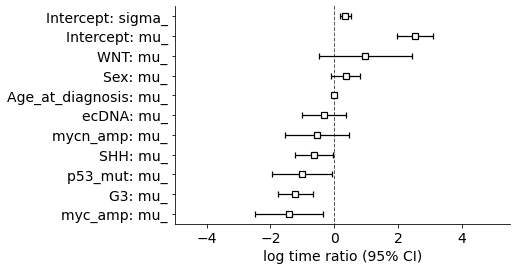

In [21]:
# 3
formula="ecDNA + WNT + SHH + G3 + Sex + Age_at_diagnosis + p53_mut + mycn_amp + myc_amp"
lnaft_p53 = lnaft_pfs(pfs,formula,"out/lnaft_ecDNA_myc_fam")